In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
from scipy import stats
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
import random

In [2]:
def dataset(mu,sigma,pi):
    for i in range(k):
        samplesB = np.random.multivariate_normal(mu[i],sigma[i],int(N*pi[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

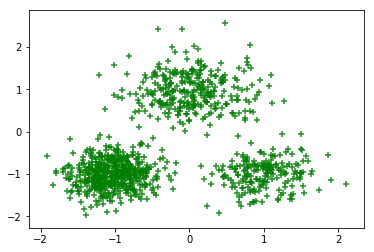

In [3]:
#初期設定
N = 1000 #データ数
#mu = [[-3,-3],[2,2]]
mu = [[0,1],[-1,-1],[1,-1],[3,1]]
sigma = [[[0.2,0.],[0.,0.2]],[[0.1,0.],[0.,0.1]],[[0.1,0.],[0.,0.1]],[[0.2,0.],[0.,0.2]]]
pi=[0.3,0.5,0.2,]
k=3 #データ群の個数
K=8 #分布の個数
D=2 #次元
samples = dataset(mu,sigma,pi)
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.2)

In [4]:
clus_center = []
for i in range(K):
    clus_center.append([random.uniform(-2,2),random.uniform(-2,2)])
print(clus_center)

[[0.7773394153906588, -0.8725822609065075], [-0.9602355235735849, -1.441968559171272], [-1.7219291265497296, 1.8335589368802303], [1.5098073656028461, 1.2619453430600833], [1.6816285983633534, -1.1174322927626523], [1.9280143188168588, 1.9258162545994733], [0.4255227545590121, -0.16665821926022728], [-0.724484157279619, -0.3069132102793959]]


In [5]:
class KMeans:
    def __init__(self):
        
        #クラスタの色
        self.color = ["r","b","c","m","y","g","k", '#f781bf']
        
        #二値指示変数
        self.r = [1,0]
        
        #クラスタ数
        self.k = K
        
        #データ数
        self.node = 300
        
    def cluster_center(self,mu2):
        
        #クラスター中心の初期値
        x = [mu2[i][0] for i in range(K)]
        y = [mu2[i][1] for i in range(K)]
        self.u = [x,y]
        
    def param_init(self):
        self.count = []
        self.sum = []
        self.t =[]
        self.clus = []
        self.b = []
        
    def figure_plot(self,sample,u,k,clus):
        X=sample[:,0]
        Y=sample[:,1]
        #新しい描画を開始
        plt.figure()
        plt.scatter(sample[:,0],sample[:,1],c=clus,s=20,marker='+',edgecolors='k',alpha=0.4)
        plt.scatter(u[0][0:k],u[1][0:k],c=self.color,s=100,marker="x",edgecolors='k')
        self.distance(sample,u,k)  
        
    def distance(self,sample,u,k):
        #変数の初期化
        self.param_init()
        X=sample[:,0]
        Y=sample[:,1]
        #配列の準備
        for i in range(0,k):
            self.b.append([u[0][i],u[1][i]])
            self.count.append(0)
            self.sum.append([0.0,0.0])
            self.t.append(0)
        self.sum = np.array(self.sum)
        
        for i,j in zip(X,Y):
            distance = []
            a = np.array([i, j])
            
            #各中心と各データの二乗距離
            for i in range(0,k):
                distance.append(np.linalg.norm(self.b[i] - a))
            
            #クラス分け
            self.clus.append(self.color[distance.index(min(distance))])
            self.count[distance.index(min(distance))] += 1
            self.sum[distance.index(min(distance))] += a
        
        #クラスタ中心の更新
        for i in range(0,k):
            self.t[i] = self.sum[i]/self.count[i]
        for i in range(0,2):
            for j in range(0,k):
                self.u[i][j] = self.t[j][i]

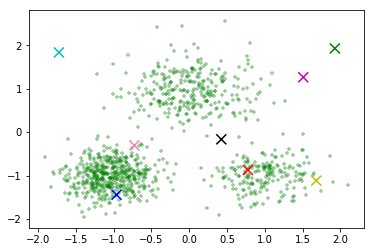

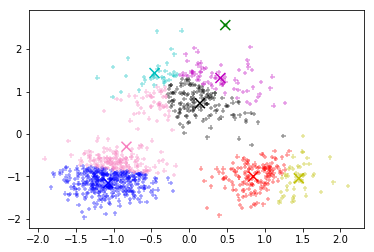

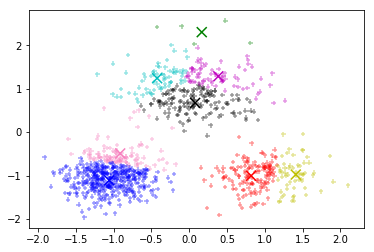

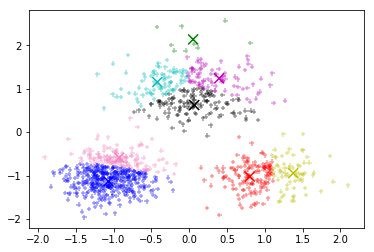

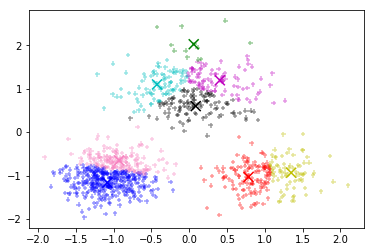

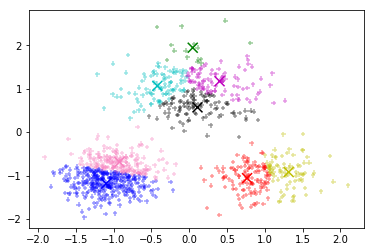

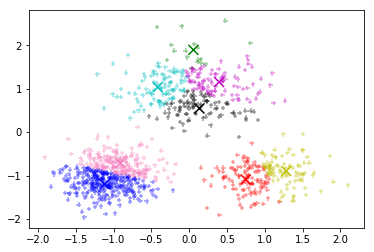

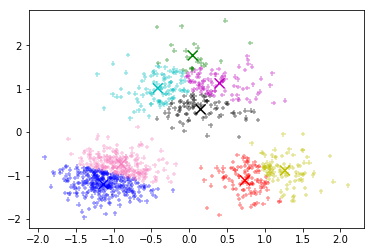

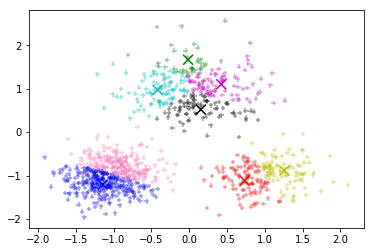

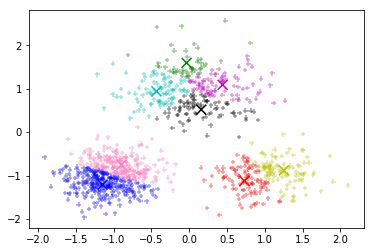

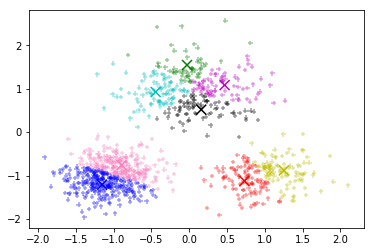

In [6]:
km = KMeans()
km.cluster_center(clus_center)
km.figure_plot(samples,km.u,km.k,km.color[5])
for i in range(10):
    km.figure_plot(samples,km.u,km.k,km.clus)
clus_center=[]
for i in range(K):
    clus_center.append([km.u[0][i],km.u[1][i]])

In [7]:
clus_center

[[0.73147692210972381, -1.1243635891825077],
 [-1.1560785110679042, -1.2081033905771943],
 [-0.44507573539119255, 0.8932006598834481],
 [0.47738786911461634, 1.0751611241206942],
 [1.2531734770425771, -0.88233444115631154],
 [-0.04241136717664945, 1.5219878462151599],
 [0.17272854072914562, 0.51914202426599376],
 [-0.88797251506332053, -0.76378491852726726]]

In [8]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
        
    return gauss

In [9]:
def draw(gauss):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    #plt.xlim(-5.1, 5.1)
    #plt.ylim(-5.1, 5.1)
    plt.scatter(samples[:,0],samples[:,1],color="g",marker='+',alpha=0.3)

In [10]:
def draw2(gauss,ganma):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    
    for i in range(K):
        z = gauss[i].pdf(pos)
        if pi[i] > 0.01: 
            plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        #plt.xlim(min(samples[:,0])+0.1,max(samples[:,0])+0.1)
        #plt.ylim(min(samples[:,1])+0.1,max(samples[:,1])+0.1)
        plt.scatter(samples[i][0],samples[i][1],color="g",marker='+',alpha=0.3)

In [11]:
print(type(clus_center))

<class 'list'>


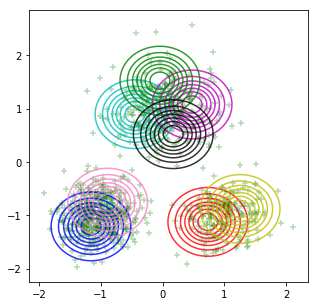

In [12]:
g_sigma = [[[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]]]
pi = [1.0/K for i in range(K)]
clus = ["r","b","c","m","y","g","k", '#f781bf']
gauss = make_gauss_model(clus_center,g_sigma)
draw(gauss)

In [13]:
def ganma_cal():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

In [14]:
def cal(ganma):
    N_k = []
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
    return N_k

In [15]:
ganma = ganma_cal()
N_k = []
N_k = cal(ganma)
print(N_k)
mu = np.zeros((K,D))
S = np.zeros((K,D,D))

[100.88741470644129, 259.53812962132474, 83.149298049553551, 72.49318429107818, 99.903710098988199, 65.692743958760488, 77.441875373073046, 240.89364390077969]


In [16]:
def cal_3(N_k,ganma):
    #行列の初期化
    #mu = np.zeros((K,D))
    #S = np.zeros((K,D,D))
    for k in range(K):
        sum_r = 0.0
        sum_x = 0.0
        sum_y = 0.0
        for n in range(N):
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [samples[j]-mu[k] for j in range(N)]
        tmp = np.zeros((1,D,D))
        for n in range(N):
            tmp += (ganma[n][k]*sigma[n])*sigma[n][:, np.newaxis]
        tmp2 = tmp/N_k[k]
        S[k] = tmp2
    return mu,S

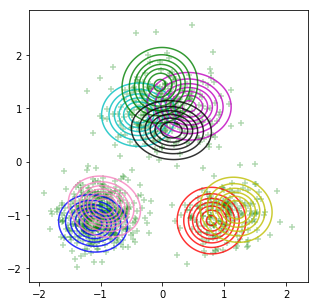

In [17]:
mu,S = cal_3(N_k,ganma)
gauss = make_gauss_model(mu,S)
draw2(gauss,ganma)

In [18]:
def M_step(N_k,mu,S):
    alpha_0 = 0.001
    beta_0 = 0.001
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m_0[j] for j in range(K)]
    for k in range(K):
        tmp = beta_0*N_k[k]*sigma[k]*sigma[k][:, np.newaxis]/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    return alpha,beta,nu,m,W

In [19]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    for n in range(N):
        tmp = [np.exp(np.array(E_ln_pi[k]) + np.array(E_ln_A[k])/2 - D*math.log(2*math.pi)/2-np.array(E_mu_A[n][k])/2) for k in range(K)]
        for k in range(K):
            if tmp[k] < 1e-10:
                tmp[k] = 1e-10
        tmp2 = np.array(tmp)/sum(tmp)
        
        r.append(tmp2)
    return E_ln_A,E_ln_pi,E_mu_A,r

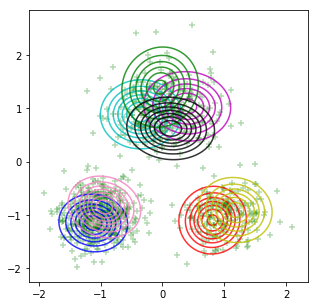

count:0
[ 0.10043824  0.25916679  0.08269148  0.0720302   0.09945406  0.06522647
  0.07698129  0.24051314]


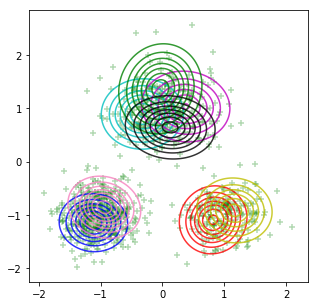

count:1
[ 0.09986794  0.26115793  0.08408335  0.07299728  0.09983245  0.06383671
  0.07564264  0.23908337]


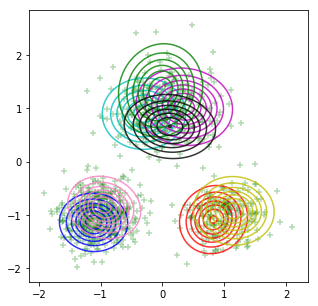

count:2
[ 0.09895522  0.26274718  0.0859124   0.07456508  0.10073078  0.06251774
  0.07357616  0.23749711]


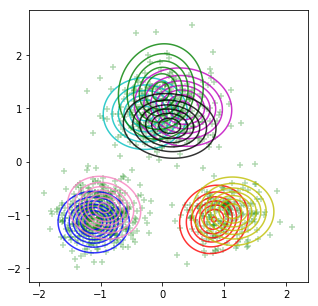

count:3
[ 0.09735392  0.2643488   0.08841004  0.07666344  0.10229295  0.06111827
  0.07045073  0.23586353]


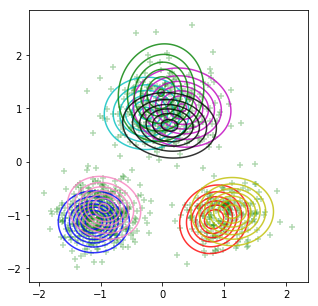

count:4
[ 0.09494854  0.26617694  0.09170296  0.07941889  0.1046542   0.05958736
  0.06600955  0.23400326]


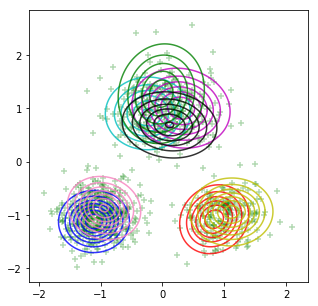

count:5
[ 0.09149083  0.26845197  0.09599098  0.08306718  0.10806955  0.05783427
  0.05990063  0.23169636]


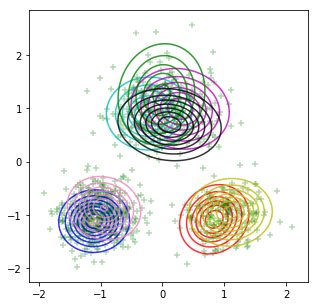

count:6
[ 0.08660126  0.27144109  0.10151659  0.08792635  0.1129189   0.0556826
  0.05174194  0.22867313]


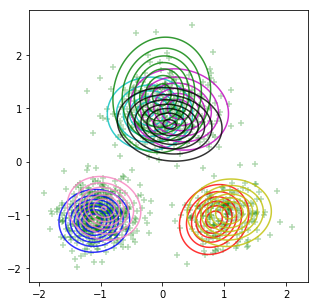

count:7
[ 0.07976705  0.27549599  0.10845519  0.09433152  0.11971325  0.05282697
  0.04133248  0.2245796 ]


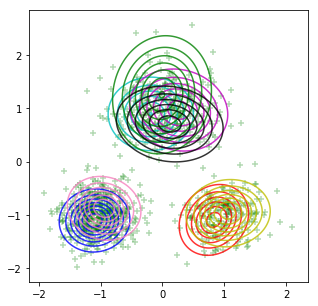

count:8
[ 0.07038119  0.28109577  0.11667075  0.10245899  0.12905705  0.04880831
  0.02909552  0.21893496]


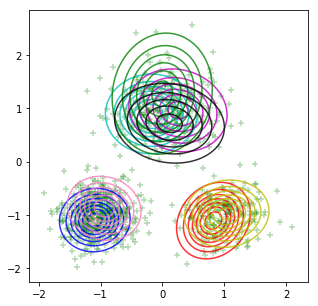

count:9
[ 0.05793511  0.28889803  0.12535503  0.11202289  0.14145734  0.04310181
  0.01665233  0.21108124]


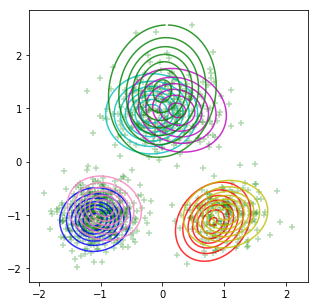

count:10
[ 0.04256298  0.29979334  0.13291866  0.12214419  0.156784    0.03546002
  0.0067142   0.20013046]


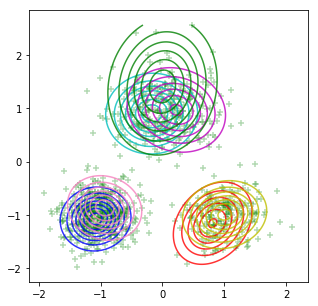

count:11
[ 0.02597952  0.31493858  0.13769514  0.13198791  0.17333817  0.02639897
  0.00126154  0.18493405]


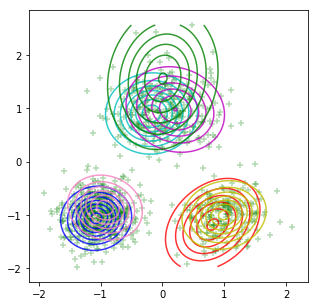

count:12
[  1.17789677e-02   3.35691082e-01   1.38812131e-01   1.41701410e-01
   1.87541518e-01   1.72514459e-02   4.51142295e-09   1.64144739e-01]


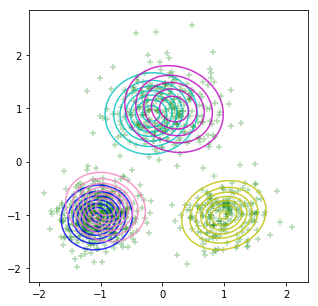

count:13
[ 0.00315175  0.3632369   0.13594508  0.15239391  0.19617869  0.00954787
  0.          0.13656195]


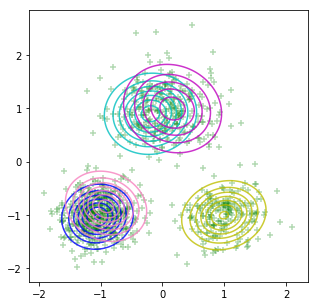

count:14
[  8.34231919e-05   3.97568162e-01   1.28342001e-01   1.65366573e-01
   1.99381933e-01   4.21454414e-03   0.00000000e+00   1.02224599e-01]


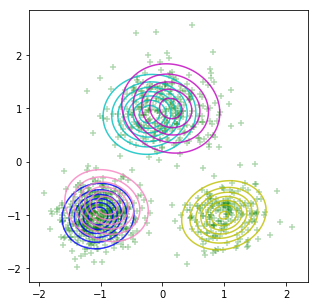

count:15
[ 0.          0.43546256  0.11479789  0.1821397   0.19973207  0.00106343
  0.          0.06433894]


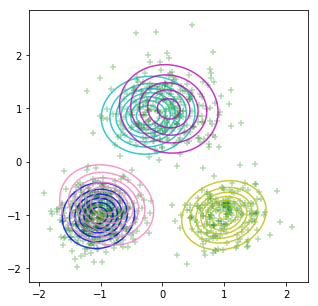

count:16
[  0.00000000e+00   4.69166283e-01   9.43283894e-02   2.04115179e-01
   1.99634288e-01   3.07982695e-08   0.00000000e+00   3.06547400e-02]


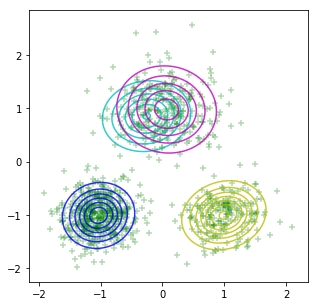

count:17
[ 0.          0.49043258  0.06736101  0.2312243   0.19955145  0.          0.
  0.00943214]


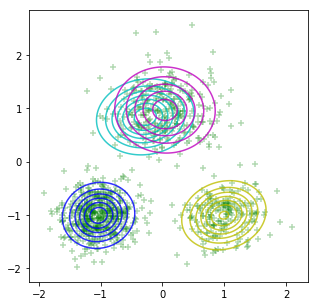

count:18
[ 0.          0.49870702  0.03783294  0.26073897  0.19955424  0.          0.
  0.0011971 ]


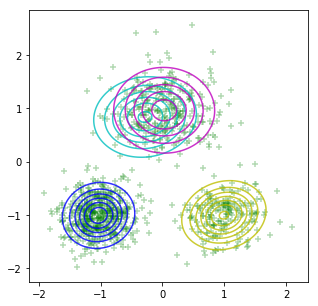

count:19
[  0.00000000e+00   5.00212546e-01   1.40837551e-02   2.84543099e-01
   1.99617349e-01   0.00000000e+00   0.00000000e+00   4.39460792e-14]


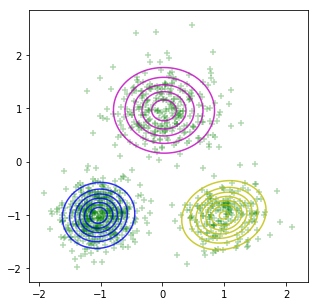

count:20
[ 0.          0.50012444  0.00250095  0.29621777  0.19966889  0.          0.
  0.        ]


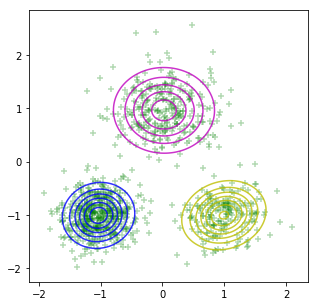

count:21
[  0.00000000e+00   5.00038592e-01   2.86774204e-06   2.99080900e-01
   1.99695829e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]


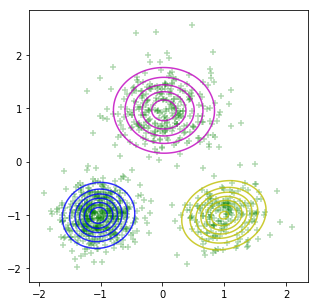

count:22
[ 0.          0.50000739  0.          0.29928488  0.19970262  0.          0.
  0.        ]


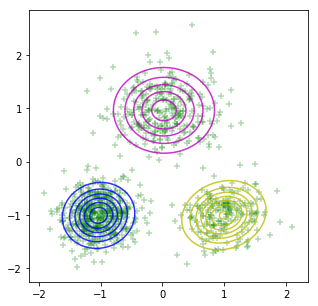

count:23
[ 0.          0.49999898  0.          0.29929405  0.19970186  0.          0.
  0.        ]


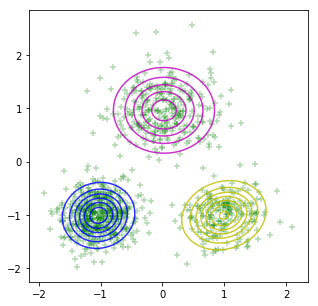

count:24
[ 0.          0.49999757  0.          0.2992957   0.19970162  0.          0.
  0.        ]


In [20]:
count = 25
pi2 = []
for i in range(count):
    alpha,beta,nu,m,W = M_step(N_k,mu,S)
    E_ln_A,E_ln_pi,E_mu_A,ganma = E_step(alpha,beta,nu,m,W)
    pi2.append(pi)
    pi = np.exp(E_ln_pi)
    N_k = cal(ganma)
    mu,S = cal_3(N_k,ganma)
    gauss = make_gauss_model(mu,S)
    draw2(gauss,ganma)
    #['r','g','b','y',"c", "m"]
    plt.show()
    print("count:{}".format(i))
    print(pi)

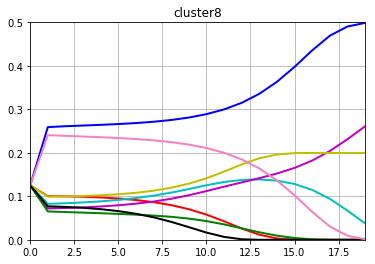

In [21]:
x = [i for i in range(count)]
y = []
for k in range(K):
    y =  [pi2[j][k] for j in range(count)]
    plt.plot(x,y,linewidth=2, color=clus[k])
    plt.title("cluster{}".format(k+1))
    plt.xlim(0,19)
    plt.ylim(0,0.5)
    plt.grid(True)
    #plt.figure()